In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
from IPython.display import clear_output
import gym
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
class DQN_Agent:
  def __init__(self, input_shape, n_actions):
    self.rng = 1
    self.rng_min = 0.1
    self.rng_decay = 0.995
    self.discount = 0.95
    self.weights='weights'
    self.decay_ctr = 0
    self.transfer_weight_ctr = 0

    self.memory = deque(maxlen=20_000)

    self.input_shape = input_shape
    self.n_actions = n_actions
    self.model = self.create_model()
    self.target_model = self.create_model()
    self.transfer_weights()

  def create_model(self):
    input = Input(shape=self.input_shape)
    x = Conv2D(16, kernel_size=(8,8), strides=(4,4), padding='same', activation='relu')(input)
    x = Conv2D(32, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu')(x)
    x = Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    V = Dense(1, activation='linear')(x)
    A = Dense(self.n_actions, activation='linear')(x)
    Q = V + tf.subtract(A, tf.reduce_mean(A, axis=1, keepdims=True))
    
    model = Model(inputs=input, outputs=Q)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    return model

  def remember(self, state, action, reward, state_, done):
    self.memory.append([state, action, reward, state_, done])

  def save(self):
    self.model.save_weights(self.weights)

  def load(self):
    self.model.load_weights(self.weights)
    self.transfer_weights()

  def action(self, state):
    if random.random() < self.rng:
      return random.randint(0, self.n_actions - 1)
    else:
      return np.argmax(self.predict(state))

  def predict(self, state):
    return self.model.predict(np.expand_dims(state, axis=0))

  def train(self):
    if len(self.memory) < 5_000:
      return

    self.decay_ctr += 1
    self.transfer_weight_ctr += 1

    mini_batch = random.sample(self.memory, 32)
    states = np.array([memory[0] for memory in mini_batch])
    states_ = np.array([memory[3] for memory in mini_batch])
    qs = self.model.predict(states)
    qs_ = self.target_model.predict(states_)

    X = states
    y = []

    for i, memory in enumerate(mini_batch):
      action = memory[1]
      reward = memory[2]
      done = memory[4]

      if done:
        q = reward
      else:
        q = reward + self.discount * np.max(qs_[i])

      qs[i][action] = q
      y.append(qs)
    
    self.model.fit(X, np.array(y), verbose=0, shuffle=False)

    if self.decay_ctr > 10:
      self.decay_rng()
      self.decay_ctr = 0

    if self.transfer_weight_ctr > 50:
      self.transfer_weights()
      self.transfer_weight_ctr = 0

  def decay_rng(self):
    self.rng = self.rng * self.rng_decay
    if self.rng < self.rng_min:
      self.rng = self.rng_min

  def transfer_weights(self):
    self.target_model.set_weights(self.model.get_weights())

In [7]:
env = gym.make('Breakout-v0')

In [8]:
agent = DQN_Agent((84, 84, 2) , env.action_space.n)
score_record = []

In [9]:
agent.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 84, 84, 2)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 21, 21, 16)   2064        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 11, 11, 32)   8224        conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 11, 11, 64)   8256        conv2d_4[0][0]                   
______________________________________________________________________________________________

In [10]:
observation = np.zeros((84, 84, 3), dtype='float')

def convert_image(data):
    img = Image.fromarray(data).convert("L")
    img = img.resize((84,84))
    return np.reshape(np.array(img), (84, 84, 1))

def add_image(observation, observation_):
    observation_ = observation_ / 255
    observation[:,:,0] = observation[:,:,1]
    observation[:,:,1] = observation[:,:,2]
    observation[:,:,2] = observation_[:,:,0]
    return observation

In [11]:
episodes = 50
for episode in range(1, (episodes + 1)):
  state = env.reset()
  observation = add_image(observation, convert_image(state))
  done = False
  score = 0
  train_step = 0
  while not done:
    env.render()
    action = agent.action(observation[:,:,1:])
    state, reward, done, info = env.step(action)
    observation = add_image(observation, convert_image(state))
    score += reward
    
    train_step += 1

    reward = (reward * 10) + 1
    
    if done:
      reward = -20
    
    agent.remember(observation[:,:,0:2], action, reward, observation[:,:,1:], done)
    if train_step > 15:
        agent.train()
        train_step = 0

    if done:
      clear_output(wait=True)
      print(f'Episode: {episode}\nScore: {score}\nAgent RNG: {agent.rng}')
      score_record.append(score)
    
env.close()

Episode: 50
Score: 1.0
Agent RNG: 0.8265651079747222


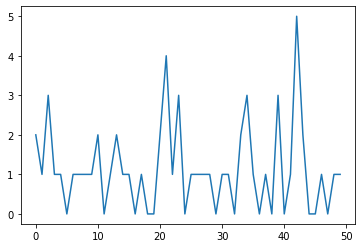

In [12]:
plt.plot(score_record)

In [8]:
def save_score():
  fh = open('score.txt', 'a')
  fh.write(score)
  fh.close()